# 株式分析結果レビュー

このノートブックはbackend分析モジュールの結果を包括的に分析・検証します：
- HL比率分析
- ミネルヴィーニ基準分析
- 相対強度分析
- チャート分類
- 統合分析

## 設定とインポート

In [ ]:
import sys
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 分析モジュールをインポート（更新されたモジュールを再読み込み）
import importlib  # noqa: E402
if 'integrated_analysis' in sys.modules:
    importlib.reload(sys.modules['integrated_analysis'])

from market_pipeline.analysis.integrated_analysis import (  # noqa: E402
    get_comprehensive_analysis,
    get_multi_date_analysis,
    get_top_stocks_by_criteria,
    get_stocks_meeting_criteria,
    create_analysis_summary,
    check_database_coverage
)

# プロット設定
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("設定完了！")

## データベース接続と構造分析

In [10]:
# データベースパス
DATA_DIR = "/Users/tak/Markets/Stocks/Stock-Analysis/data"
RESULTS_DB_PATH = os.path.join(DATA_DIR, "analysis_results.db")
MASTER_DB_PATH = os.path.join(DATA_DIR, "master.db")
JQUANTS_DB_PATH = os.path.join(DATA_DIR, "jquants.db")

print(f"分析結果DB: {os.path.exists(RESULTS_DB_PATH)}")
print(f"マスターDB: {os.path.exists(MASTER_DB_PATH)}")
print(f"JQuantsDB: {os.path.exists(JQUANTS_DB_PATH)}")

分析結果DB: True
マスターDB: True
JQuantsDB: True


In [11]:
# データベースカバレッジチェック
print("=== データベースカバレッジ分析 ===")
try:
    coverage = check_database_coverage()
    for key, value in coverage.items():
        print(f"{key}: {value:,}")
except Exception as e:
    print(f"カバレッジチェックエラー: {e}")

=== データベースカバレッジ分析 ===
hl_ratio_records: 4,163
minervini_records: 4,863,285
relative_strength_records: 4,886,903
hl_ratio_dates: 1
minervini_dates: 1,229
relative_strength_dates: 1,227
hl_ratio_codes: 4,163
minervini_codes: 4,244
relative_strength_codes: 4,279


In [12]:
# テーブル構造の確認
def examine_table_structure(db_path, table_name):
    """データベーステーブルの構造を確認"""
    try:
        with sqlite3.connect(db_path) as conn:
            # テーブルスキーマを取得
            schema = conn.execute(f"PRAGMA table_info({table_name})").fetchall()
            
            print(f"\n=== {table_name} テーブル構造 ===")
            for col in schema:
                print(f"{col[1]} ({col[2]}) - {'NOT NULL' if col[3] else 'NULL'}")
            
            # サンプルデータを取得
            sample = pd.read_sql(f"SELECT * FROM {table_name} ORDER BY Date DESC LIMIT 3", conn)
            print(f"\nサンプルデータ ({len(sample)} 行):")
            return sample
    except Exception as e:
        print(f"{table_name}の確認エラー: {e}")
        return None

# 主要分析テーブルの確認
tables = ['hl_ratio', 'minervini', 'relative_strength']
sample_data = {}

for table in tables:
    sample_data[table] = examine_table_structure(RESULTS_DB_PATH, table)
    print(sample_data[table])


=== hl_ratio テーブル構造 ===
Code (TEXT) - NULL
HlRatio (REAL) - NULL
Date (TEXT) - NULL
Weeks (INTEGER) - NULL
MedianRatio (REAL) - NULL

サンプルデータ (3 行):
    Code  HlRatio        Date  Weeks  MedianRatio
0  89660    100.0  2025-07-11     52    58.974359
1  19720    100.0  2025-07-11     52    25.426357
2  85150    100.0  2025-07-11     52    33.974359

=== minervini テーブル構造 ===
Date (TEXT) - NULL
Code (TEXT) - NULL
Close (REAL) - NULL
Sma50 (REAL) - NULL
Sma150 (REAL) - NULL
Sma200 (REAL) - NULL
Type_1 (REAL) - NULL
Type_2 (REAL) - NULL
Type_3 (REAL) - NULL
Type_4 (REAL) - NULL
Type_5 (REAL) - NULL
Type_6 (REAL) - NULL
Type_7 (REAL) - NULL
Type_8 (REAL) - NULL

サンプルデータ (3 行):
                  Date   Code   Close    Sma50       Sma150    Sma200  Type_1  \
0  2025-07-11 00:00:00  99970   962.0   897.16   876.280000   838.970     1.0   
1  2025-07-11 00:00:00  99960  2103.0  1930.18  1922.113333  1865.575     1.0   
2  2025-07-11 00:00:00  99940  2433.0  2573.64  2764.073333  2803.140     0.0

## データ概要と品質チェック

In [13]:
# データベース内の利用可能日付を取得
def get_available_dates():
    """全ての利用可能な分析日付を取得"""
    try:
        with sqlite3.connect(RESULTS_DB_PATH) as conn:
            dates_query = """
            SELECT DISTINCT Date 
            FROM hl_ratio 
            ORDER BY Date DESC
            """
            dates_df = pd.read_sql(dates_query, conn)
            return dates_df['Date'].tolist()
    except Exception as e:
        print(f"日付取得エラー: {e}")
        return []

available_dates = get_available_dates()
print(f"利用可能な分析日付: {len(available_dates)}件")
if available_dates:
    print(f"最新: {available_dates[0]}")
    print(f"最古: {available_dates[-1]}")
    print(f"直近の日付: {available_dates[:5]}")

利用可能な分析日付: 1件
最新: 2025-07-11
最古: 2025-07-11
直近の日付: ['2025-07-11']


In [14]:
# データ品質分析
def analyze_data_quality(date):
    """特定日付のデータ品質を分析"""
    try:
        with sqlite3.connect(RESULTS_DB_PATH) as conn:
            quality_query = """
            SELECT 
                'hl_ratio' as table_name,
                COUNT(*) as total_records,
                COUNT(CASE WHEN HlRatio IS NULL THEN 1 END) as null_values,
                MIN(HlRatio) as min_value,
                MAX(HlRatio) as max_value,
                AVG(HlRatio) as avg_value
            FROM hl_ratio WHERE Date = ?
            
            UNION ALL
            
            SELECT 
                'relative_strength' as table_name,
                COUNT(*) as total_records,
                COUNT(CASE WHEN RelativeStrengthIndex IS NULL THEN 1 END) as null_values,
                MIN(RelativeStrengthIndex) as min_value,
                MAX(RelativeStrengthIndex) as max_value,
                AVG(RelativeStrengthIndex) as avg_value
            FROM relative_strength WHERE Date = ?
            
            UNION ALL
            
            SELECT 
                'minervini' as table_name,
                COUNT(*) as total_records,
                COUNT(CASE WHEN Close IS NULL THEN 1 END) as null_values,
                MIN(Close) as min_value,
                MAX(Close) as max_value,
                AVG(Close) as avg_value
            FROM minervini WHERE DATE(Date) = ?
            """
            
            quality_df = pd.read_sql(quality_query, conn, params=[date, date, date])
            return quality_df
    except Exception as e:
        print(f"データ品質分析エラー: {e}")
        return None

if available_dates:
    latest_date = available_dates[0]
    quality_analysis = analyze_data_quality(latest_date)
    if quality_analysis is not None:
        print(f"\n{latest_date}のデータ品質分析:")
        print(quality_analysis.to_string(index=False))


2025-07-11のデータ品質分析:
       table_name  total_records  null_values  min_value  max_value   avg_value
         hl_ratio           4163            0        0.0      100.0   54.891658
relative_strength           4208            0        1.0       99.0   50.000000
        minervini           4548           75        9.0   326000.0 4867.261681


## 包括的分析結果

In [15]:
# 最新日付の包括的分析を取得
if available_dates:
    latest_date = available_dates[0]
    print(f"{latest_date}の包括的分析")
    
    comprehensive_df = get_comprehensive_analysis(latest_date)
    
    if not comprehensive_df.empty:
        print(f"\n分析対象銘柄数: {len(comprehensive_df)}銘柄")
        print(f"カラム: {list(comprehensive_df.columns)}")
        
        # 要約統計の表示
        numeric_cols = comprehensive_df.select_dtypes(include=[np.number]).columns
        print("\n要約統計:")
        print(comprehensive_df[numeric_cols].describe())
    else:
        print("包括的分析データが利用できません")
else:
    print("分析日付が利用できません")
    comprehensive_df = pd.DataFrame()

2025-07-11の包括的分析

分析対象銘柄数: 4163銘柄
カラム: ['Date', 'Code', 'HlRatio', 'MedianRatio', 'hl_weeks', 'minervini_close', 'Sma50', 'Sma150', 'Sma200', 'minervini_type_1', 'minervini_type_2', 'minervini_type_3', 'minervini_type_4', 'minervini_type_5', 'minervini_type_6', 'minervini_type_7', 'minervini_type_8', 'RelativeStrengthPercentage', 'RelativeStrengthIndex', 'minervini_score', 'composite_score']

要約統計:
           HlRatio  MedianRatio  hl_weeks  minervini_close          Sma50  \
count  4163.000000  4163.000000    4163.0      4161.000000    4160.000000   
mean     54.891658    43.115229      52.0      4596.694641    4460.239166   
std      28.193045    17.000198       0.0     17745.166413   17266.977529   
min       0.000000   -21.530945      52.0         9.000000       8.040000   
25%      32.103072    33.333333      52.0       738.500000     714.865000   
50%      55.555556    44.655907      52.0      1467.000000    1425.690000   
75%      80.101767    54.558046      52.0      2785.000000 

## トップパフォーマンス銘柄分析

In [16]:
# 異なる基準でトップパフォーマンス銘柄を分析
if available_dates and not comprehensive_df.empty:
    latest_date = available_dates[0]
    
    criteria_list = ['hl_ratio', 'rsi', 'minervini', 'composite']
    top_stocks_analysis = {}
    
    for criteria in criteria_list:
        try:
            # hl_ratio基準の場合はMedianRatioも考慮
            if criteria == 'hl_ratio':
                top_stocks = get_top_stocks_by_criteria(latest_date, criteria=criteria, limit=10, include_median_ratio=True)
            else:
                top_stocks = get_top_stocks_by_criteria(latest_date, criteria=criteria, limit=10)
            
            if not top_stocks.empty:
                top_stocks_analysis[criteria] = top_stocks
                print(f"\n=== {criteria.upper()}基準トップ10銘柄 ===")
                
                # 表示用カラムの選択
                if criteria == 'hl_ratio':
                    display_cols = ['Code', 'HlRatio', 'MedianRatio', 'hl_weeks']
                elif criteria == 'rsi':
                    display_cols = ['Code', 'RelativeStrengthIndex', 'RelativeStrengthPercentage']
                elif criteria == 'minervini':
                    display_cols = ['Code', 'minervini_score', 'minervini_close']
                else:  # composite
                    display_cols = ['Code', 'composite_score', 'HlRatio', 'RelativeStrengthIndex', 'minervini_score']
                
                available_cols = [col for col in display_cols if col in top_stocks.columns]
                if available_cols:
                    print(top_stocks[available_cols].head().to_string(index=False))
                else:
                    print(f"期待されるカラムが見つかりません。利用可能: {list(top_stocks.columns)}")
        except Exception as e:
            print(f"{criteria}基準でのトップ銘柄分析エラー: {e}")


=== HL_RATIO基準トップ10銘柄 ===
 Code  HlRatio  MedianRatio  hl_weeks
171A0    100.0     0.000000        52
89680    100.0    21.327684        52
94790    100.0    24.666667        52
19720    100.0    25.426357        52
96280    100.0    27.163462        52

=== RSI基準トップ10銘柄 ===
 Code  RelativeStrengthIndex  RelativeStrengthPercentage
33500              99.000000                  170.092605
23340              98.976705                  152.119230
21340              98.953411                  143.210526
65740              98.930116                  142.486717
48890              98.906822                  134.593562

=== MINERVINI基準トップ10銘柄 ===
 Code  minervini_score  minervini_close
15420              8.0          16300.0
31820              8.0           1652.0
63650              8.0           4650.0
88360              8.0             43.0
16240              8.0          65290.0

=== COMPOSITE基準トップ10銘柄 ===
 Code  composite_score   HlRatio  RelativeStrengthIndex  minervini_score
91640       

## フィルタリング・スクリーニング分析

In [17]:
# 異なるフィルター基準で銘柄をスクリーニング
if available_dates:
    latest_date = available_dates[0]
    print(f"基準日：{latest_date}")
    
    filter_scenarios = [
        {"hl_ratio_min": 70.0, "rsi_min": 60.0, "minervini_min": 3, "name": "中程度基準"},
        {"hl_ratio_min": 80.0, "rsi_min": 70.0, "minervini_min": 5, "name": "厳格基準"},
        {"hl_ratio_min": 90.0, "rsi_min": 80.0, "minervini_min": 7, "name": "非常に厳格基準"}
    ]
    
    screening_results = {}
    
    for scenario in filter_scenarios:
        name = scenario.pop('name')
        try:
            filtered_stocks = get_stocks_meeting_criteria(latest_date, **scenario)
            screening_results[name] = len(filtered_stocks)
            
            print(f"\n=== {name} ===")
            print(f"HL比率 >= {scenario['hl_ratio_min']}, RSI >= {scenario['rsi_min']}, ミネルヴィーニ >= {scenario['minervini_min']}")
            print(f"基準を満たす銘柄数: {len(filtered_stocks)}銘柄")
            
            if not filtered_stocks.empty:
                display_cols = ['Code', 'HlRatio', 'RelativeStrengthIndex', 'minervini_score', 'composite_score']
                available_cols = [col for col in display_cols if col in filtered_stocks.columns]
                print(filtered_stocks[available_cols].head().to_string(index=False))
                
        except Exception as e:
            print(f"{name}でのスクリーニングエラー: {e}")
    
    # スクリーニング結果のサマリー
    print("\n=== スクリーニングサマリー ===")
    for name, count in screening_results.items():
        print(f"{name}: {count}銘柄")

基準日：2025-07-11

=== 中程度基準 ===
HL比率 >= 70.0, RSI >= 60.0, ミネルヴィーニ >= 3
基準を満たす銘柄数: 1085銘柄
 Code   HlRatio  RelativeStrengthIndex  minervini_score  composite_score
91640 99.818841              98.068220              8.0        99.154824
73180 99.180999              98.627288              8.0        99.123315
71150 99.951456              97.625624              8.0        99.030832
93860 99.696786              97.695507              8.0        98.956917
70840 99.400685              97.206323              8.0        98.642803

=== 厳格基準 ===
HL比率 >= 80.0, RSI >= 70.0, ミネルヴィーニ >= 5
基準を満たす銘柄数: 695銘柄
 Code   HlRatio  RelativeStrengthIndex  minervini_score  composite_score
91640 99.818841              98.068220              8.0        99.154824
73180 99.180999              98.627288              8.0        99.123315
71150 99.951456              97.625624              8.0        99.030832
93860 99.696786              97.695507              8.0        98.956917
70840 99.400685              97.206323

## データ可視化

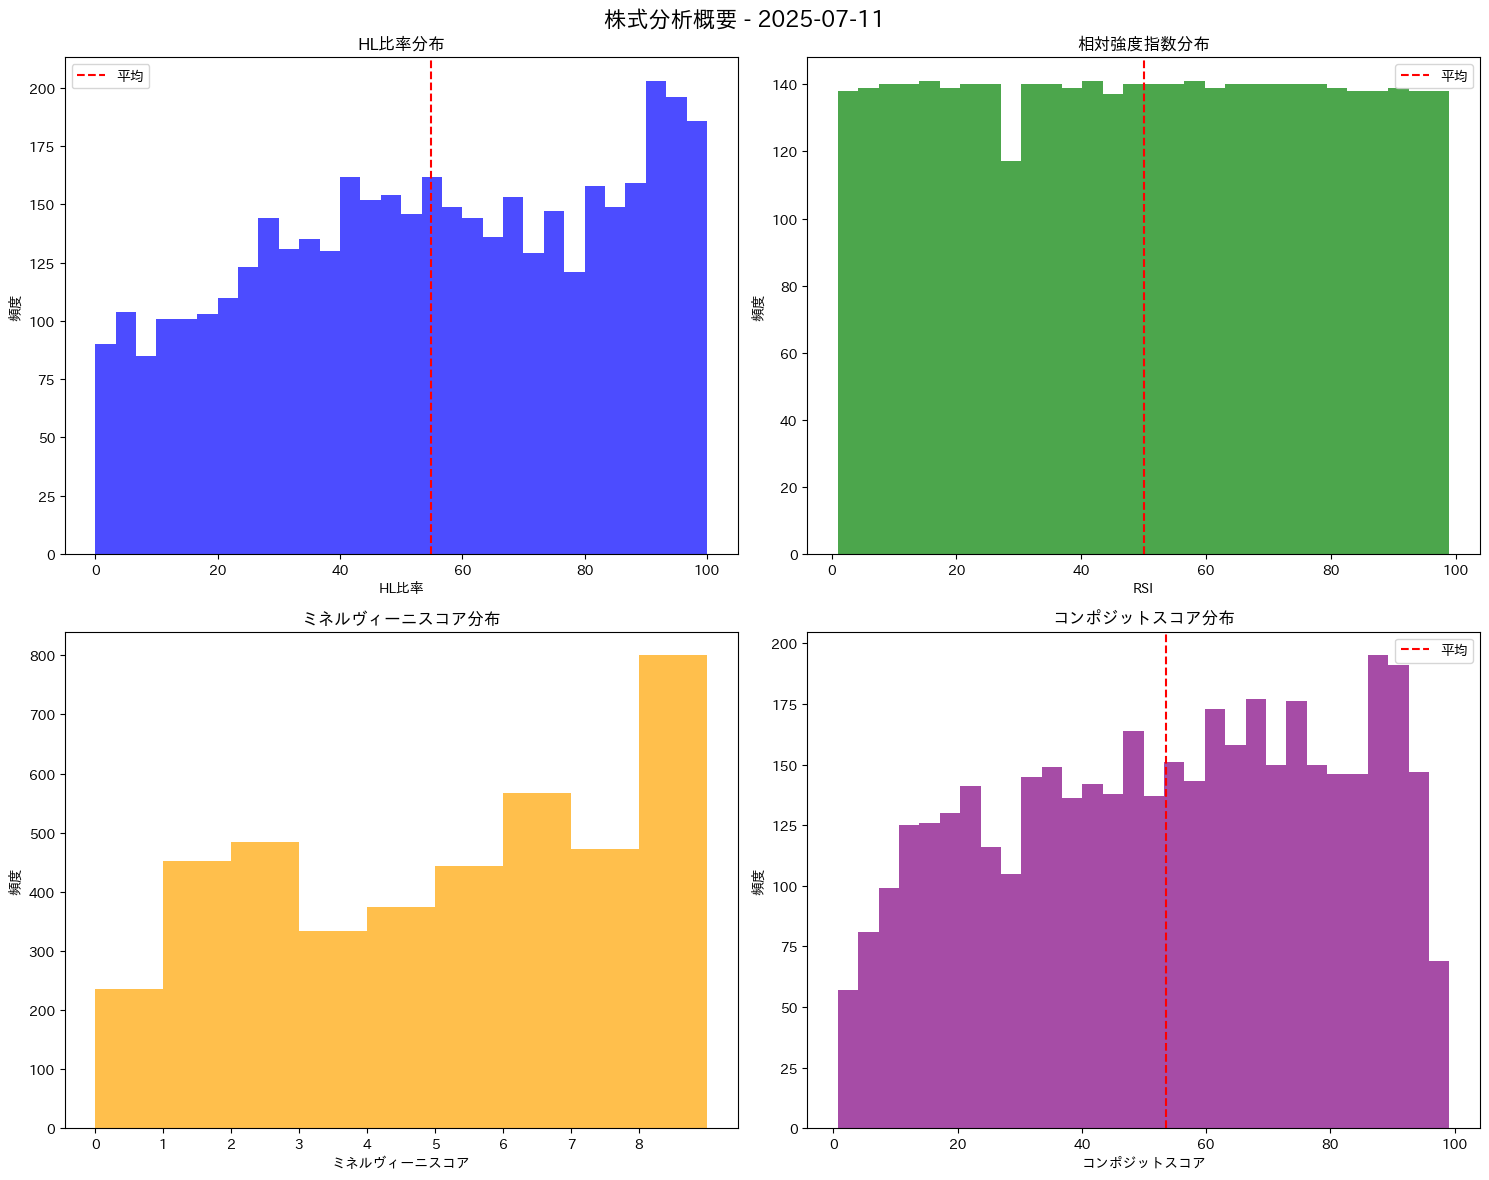

In [18]:
# 分析結果の可視化
if not comprehensive_df.empty:
    # サブプロットを作成
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'株式分析概要 - {latest_date}', fontsize=16)
    
    # HL比率分布
    if 'HlRatio' in comprehensive_df.columns:
        axes[0, 0].hist(comprehensive_df['HlRatio'].dropna(), bins=30, alpha=0.7, color='blue')
        axes[0, 0].set_title('HL比率分布')
        axes[0, 0].set_xlabel('HL比率')
        axes[0, 0].set_ylabel('頻度')
        axes[0, 0].axvline(comprehensive_df['HlRatio'].mean(), color='red', linestyle='--', label='平均')
        axes[0, 0].legend()
    
    # RSI分布
    if 'RelativeStrengthIndex' in comprehensive_df.columns:
        axes[0, 1].hist(comprehensive_df['RelativeStrengthIndex'].dropna(), bins=30, alpha=0.7, color='green')
        axes[0, 1].set_title('相対強度指数分布')
        axes[0, 1].set_xlabel('RSI')
        axes[0, 1].set_ylabel('頻度')
        axes[0, 1].axvline(comprehensive_df['RelativeStrengthIndex'].mean(), color='red', linestyle='--', label='平均')
        axes[0, 1].legend()
    
    # ミネルヴィーニスコア分布
    if 'minervini_score' in comprehensive_df.columns:
        axes[1, 0].hist(comprehensive_df['minervini_score'].dropna(), bins=range(0, 10), alpha=0.7, color='orange')
        axes[1, 0].set_title('ミネルヴィーニスコア分布')
        axes[1, 0].set_xlabel('ミネルヴィーニスコア')
        axes[1, 0].set_ylabel('頻度')
        axes[1, 0].set_xticks(range(0, 9))
    
    # コンポジットスコア分布
    if 'composite_score' in comprehensive_df.columns:
        axes[1, 1].hist(comprehensive_df['composite_score'].dropna(), bins=30, alpha=0.7, color='purple')
        axes[1, 1].set_title('コンポジットスコア分布')
        axes[1, 1].set_xlabel('コンポジットスコア')
        axes[1, 1].set_ylabel('頻度')
        axes[1, 1].axvline(comprehensive_df['composite_score'].mean(), color='red', linestyle='--', label='平均')
        axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("可視化用データが利用できません")

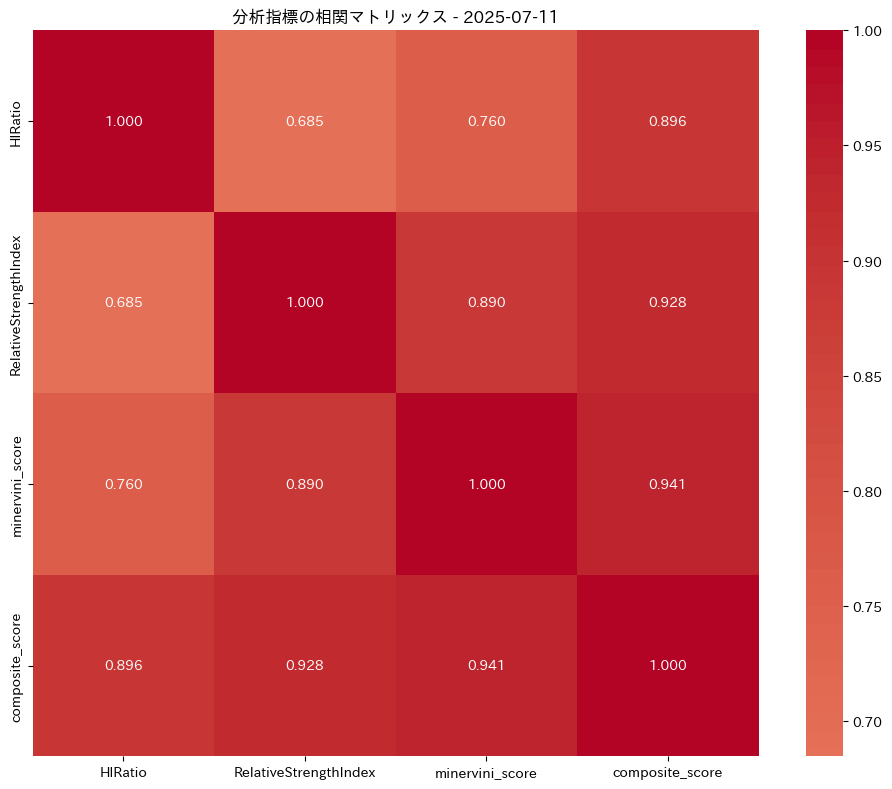


相関分析:
                       HlRatio  RelativeStrengthIndex  minervini_score  \
HlRatio                  1.000                  0.685            0.760   
RelativeStrengthIndex    0.685                  1.000            0.890   
minervini_score          0.760                  0.890            1.000   
composite_score          0.896                  0.928            0.941   

                       composite_score  
HlRatio                          0.896  
RelativeStrengthIndex            0.928  
minervini_score                  0.941  
composite_score                  1.000  


In [19]:
# 相関分析
if not comprehensive_df.empty:
    # 相関分析用の数値カラムを選択
    numeric_cols = ['HlRatio', 'RelativeStrengthIndex', 'minervini_score', 'composite_score']
    available_numeric_cols = [col for col in numeric_cols if col in comprehensive_df.columns]
    
    if len(available_numeric_cols) > 1:
        correlation_matrix = comprehensive_df[available_numeric_cols].corr()
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                   square=True, fmt='.3f')
        plt.title(f'分析指標の相関マトリックス - {latest_date}')
        plt.tight_layout()
        plt.show()
        
        print("\n相関分析:")
        print(correlation_matrix.round(3))
    else:
        print("相関分析に十分な数値カラムがありません")

## 時系列分析

In [20]:
# 選択銘柄の時系列分析
if available_dates and len(available_dates) > 1:
    # 時系列分析用のサンプル銘柄を取得
    if not comprehensive_df.empty:
        # コンポジットスコアでトップ銘柄を選択
        if 'composite_score' in comprehensive_df.columns:
            top_stock = comprehensive_df.nlargest(1, 'composite_score')['Code'].iloc[0]
        else:
            top_stock = comprehensive_df['Code'].iloc[0]
        
        # 時系列データを取得（利用可能であれば過去30日間）
        end_date = available_dates[0]
        start_idx = min(30, len(available_dates) - 1)
        start_date = available_dates[start_idx]
        
        print(f"銘柄の時系列分析: {top_stock}")
        print(f"期間: {start_date} から {end_date}")
        
        try:
            time_series_data = get_multi_date_analysis(start_date, end_date, top_stock)
            
            if not time_series_data.empty:
                print(f"{len(time_series_data)}データポイントを発見")
                
                # 時系列プロット
                fig, axes = plt.subplots(2, 2, figsize=(15, 10))
                fig.suptitle(f'時系列分析 - 銘柄{top_stock}', fontsize=16)
                
                # 日付カラムをdatetimeに変換（存在する場合）
                if 'Date' in time_series_data.columns:
                    time_series_data['Date'] = pd.to_datetime(time_series_data['Date'])
                    x_axis = time_series_data['Date']
                else:
                    x_axis = range(len(time_series_data))
                
                # HL比率の推移
                if 'HlRatio' in time_series_data.columns:
                    axes[0, 0].plot(x_axis, time_series_data['HlRatio'], marker='o')
                    axes[0, 0].set_title('HL比率の推移')
                    axes[0, 0].set_ylabel('HL比率')
                    axes[0, 0].tick_params(axis='x', rotation=45)
                
                # RSIの推移
                if 'RelativeStrengthIndex' in time_series_data.columns:
                    axes[0, 1].plot(x_axis, time_series_data['RelativeStrengthIndex'], marker='o', color='green')
                    axes[0, 1].set_title('RSIの推移')
                    axes[0, 1].set_ylabel('RSI')
                    axes[0, 1].tick_params(axis='x', rotation=45)
                
                # ミネルヴィーニスコアの推移
                if 'minervini_score' in time_series_data.columns:
                    axes[1, 0].plot(x_axis, time_series_data['minervini_score'], marker='o', color='orange')
                    axes[1, 0].set_title('ミネルヴィーニスコアの推移')
                    axes[1, 0].set_ylabel('ミネルヴィーニスコア')
                    axes[1, 0].tick_params(axis='x', rotation=45)
                
                # 株価の推移（利用可能な場合）
                if 'minervini_close' in time_series_data.columns:
                    axes[1, 1].plot(x_axis, time_series_data['minervini_close'], marker='o', color='red')
                    axes[1, 1].set_title('株価の推移')
                    axes[1, 1].set_ylabel('株価')
                    axes[1, 1].tick_params(axis='x', rotation=45)
                
                plt.tight_layout()
                plt.show()
                
                # 要約統計の表示
                numeric_ts_cols = time_series_data.select_dtypes(include=[np.number]).columns
                print("\n時系列要約統計:")
                print(time_series_data[numeric_ts_cols].describe())
            else:
                print("時系列データが利用できません")
        except Exception as e:
            print(f"時系列分析エラー: {e}")
    else:
        print("時系列分析用の銘柄データが利用できません")
else:
    print("時系列分析に十分な履歴データがありません")

時系列分析に十分な履歴データがありません


## 要約統計とレポート

In [21]:
# 最新分析の要約統計を生成
if available_dates:
    latest_date = available_dates[0]
    
    try:
        summary_stats = create_analysis_summary(latest_date)
        
        if summary_stats:
            print(f"=== {latest_date}の分析サマリー ===")
            print(f"分析対象銘柄総数: {summary_stats.get('total_stocks', 0):,}銘柄")
            print("\n平均指標:")
            print(f"  HL比率: {summary_stats.get('avg_hl_ratio', 0):.2f}")
            print(f"  RSI: {summary_stats.get('avg_rsi', 0):.2f}")
            print(f"  ミネルヴィーニスコア: {summary_stats.get('avg_minervini_score', 0):.2f}")
            print(f"  コンポジットスコア: {summary_stats.get('avg_composite_score', 0):.2f}")
            
            print("\n高品質銘柄:")
            print(f"  HL比率 >= 80: {summary_stats.get('high_hl_ratio_count', 0):,}銘柄")
            print(f"  RSI >= 70: {summary_stats.get('high_rsi_count', 0):,}銘柄")
            print(f"  ミネルヴィーニスコア >= 5: {summary_stats.get('strong_minervini_count', 0):,}銘柄")
            print(f"  コンポジットスコア >= 70: {summary_stats.get('strong_composite_count', 0):,}銘柄")
            
            # パーセンテージの計算
            total = summary_stats.get('total_stocks', 1)
            print("\nパーセンテージ:")
            print(f"  高HL比率: {(summary_stats.get('high_hl_ratio_count', 0) / total * 100):.1f}%")
            print(f"  高RSI: {(summary_stats.get('high_rsi_count', 0) / total * 100):.1f}%")
            print(f"  強ミネルヴィーニ: {(summary_stats.get('strong_minervini_count', 0) / total * 100):.1f}%")
            print(f"  強コンポジット: {(summary_stats.get('strong_composite_count', 0) / total * 100):.1f}%")
        else:
            print("要約統計が利用できません")
    except Exception as e:
        print(f"要約作成エラー: {e}")

=== 2025-07-11の分析サマリー ===
分析対象銘柄総数: 4,163銘柄

平均指標:
  HL比率: 54.89
  RSI: 50.06
  ミネルヴィーニスコア: 4.62
  コンポジットスコア: 53.53

高品質銘柄:
  HL比率 >= 80: 1,051銘柄
  RSI >= 70: 1,233銘柄
  ミネルヴィーニスコア >= 5: 2,283銘柄
  コンポジットスコア >= 70: 1,348銘柄

パーセンテージ:
  高HL比率: 25.2%
  高RSI: 29.6%
  強ミネルヴィーニ: 54.8%
  強コンポジット: 32.4%


## エラー分析とデータ検証

In [22]:
# 潜在的なデータ問題をチェック
if not comprehensive_df.empty:
    print("=== データ検証レポート ===")
    
    # 欠損値のチェック
    missing_data = comprehensive_df.isnull().sum()
    if missing_data.sum() > 0:
        print("\n欠損データ:")
        for col, count in missing_data[missing_data > 0].items():
            percentage = (count / len(comprehensive_df)) * 100
            print(f"  {col}: {count}件 ({percentage:.1f}%)")
    else:
        print("\n✓ 欠損データは見つかりませんでした")
    
    # 外れ値のチェック
    print("\n外れ値分析:")
    numeric_cols = comprehensive_df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if col in comprehensive_df.columns and not comprehensive_df[col].empty:
            Q1 = comprehensive_df[col].quantile(0.25)
            Q3 = comprehensive_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = comprehensive_df[(comprehensive_df[col] < lower_bound) | 
                                      (comprehensive_df[col] > upper_bound)]
            
            if len(outliers) > 0:
                print(f"  {col}: {len(outliers)}件の外れ値 ({len(outliers)/len(comprehensive_df)*100:.1f}%)")
            else:
                print(f"  {col}: 外れ値は検出されませんでした")
    
    # 重複銘柄コードのチェック
    if 'Code' in comprehensive_df.columns:
        duplicates = comprehensive_df['Code'].duplicated().sum()
        if duplicates > 0:
            print(f"\n⚠️ {duplicates}件の重複銘柄コードが見つかりました")
        else:
            print("\n✓ 重複銘柄コードは見つかりませんでした")
    
    print(f"\nデータ形状: {comprehensive_df.shape}")
    print(f"メモリ使用量: {comprehensive_df.memory_usage().sum() / 1024 / 1024:.2f} MB")

=== データ検証レポート ===

欠損データ:
  minervini_close: 2件 (0.0%)
  Sma50: 3件 (0.1%)
  Sma150: 5件 (0.1%)
  Sma200: 6件 (0.1%)
  minervini_type_1: 2件 (0.0%)
  minervini_type_2: 2件 (0.0%)
  minervini_type_3: 2件 (0.0%)
  minervini_type_4: 2件 (0.0%)
  minervini_type_5: 2件 (0.0%)
  minervini_type_6: 6件 (0.1%)
  minervini_type_7: 6件 (0.1%)
  minervini_type_8: 2件 (0.0%)
  RelativeStrengthPercentage: 2件 (0.0%)
  RelativeStrengthIndex: 2件 (0.0%)

外れ値分析:
  HlRatio: 外れ値は検出されませんでした
  MedianRatio: 48件の外れ値 (1.2%)
  hl_weeks: 外れ値は検出されませんでした
  minervini_close: 329件の外れ値 (7.9%)
  Sma50: 324件の外れ値 (7.8%)
  Sma150: 321件の外れ値 (7.7%)
  Sma200: 320件の外れ値 (7.7%)
  minervini_type_1: 外れ値は検出されませんでした
  minervini_type_2: 外れ値は検出されませんでした
  minervini_type_3: 外れ値は検出されませんでした
  minervini_type_4: 外れ値は検出されませんでした
  minervini_type_5: 外れ値は検出されませんでした
  minervini_type_6: 外れ値は検出されませんでした
  minervini_type_7: 823件の外れ値 (19.8%)
  minervini_type_8: 外れ値は検出されませんでした
  RelativeStrengthPercentage: 246件の外れ値 (5.9%)
  RelativeStrengthIndex: 外れ値は検出されませんでした


## 結果エクスポート

In [23]:
# さらなる使用のために分析結果をエクスポート
if not comprehensive_df.empty and available_dates:
    latest_date = available_dates[0]
    
    # 出力ディレクトリが存在しない場合は作成
    output_dir = "../output"
    os.makedirs(output_dir, exist_ok=True)
    
    # 包括的分析をエクスポート
    export_filename = f"comprehensive_analysis_{latest_date}.csv"
    export_path = os.path.join(output_dir, export_filename)
    comprehensive_df.to_csv(export_path, index=False)
    print(f"✓ 包括的分析をエクスポート: {export_path}")
    
    # 基準別トップ銘柄をエクスポート
    if 'top_stocks_analysis' in locals():
        for criteria, df in top_stocks_analysis.items():
            filename = f"top_stocks_{criteria}_{latest_date}.csv"
            filepath = os.path.join(output_dir, filename)
            df.to_csv(filepath, index=False)
            print(f"✓ トップ銘柄({criteria})をエクスポート: {filepath}")
    
    # 要約統計をエクスポート
    if 'summary_stats' in locals() and summary_stats:
        summary_df = pd.DataFrame([summary_stats])
        summary_filename = f"summary_statistics_{latest_date}.csv"
        summary_path = os.path.join(output_dir, summary_filename)
        summary_df.to_csv(summary_path, index=False)
        print(f"✓ 要約統計をエクスポート: {summary_path}")
    
    print(f"\n分析日付 {latest_date} の全エクスポートが完了しました")
else:
    print("エクスポート用データが利用できません")

✓ 包括的分析をエクスポート: ../output/comprehensive_analysis_2025-07-11.csv
✓ トップ銘柄(hl_ratio)をエクスポート: ../output/top_stocks_hl_ratio_2025-07-11.csv
✓ トップ銘柄(rsi)をエクスポート: ../output/top_stocks_rsi_2025-07-11.csv
✓ トップ銘柄(minervini)をエクスポート: ../output/top_stocks_minervini_2025-07-11.csv
✓ トップ銘柄(composite)をエクスポート: ../output/top_stocks_composite_2025-07-11.csv
✓ 要約統計をエクスポート: ../output/summary_statistics_2025-07-11.csv

分析日付 2025-07-11 の全エクスポートが完了しました


## 結論と次のステップ

このノートブックはbackend分析結果の包括的な分析と検証を提供します。主な機能：

1. **データベースカバレッジ分析** - 全分析モジュールのデータ可用性を確認
2. **データ品質チェック** - 欠損値、外れ値、データ問題を特定
3. **包括的分析** - HL比率、ミネルヴィーニ、相対強度分析の結果を統合
4. **銘柄スクリーニング** - 複数基準による銘柄フィルタリング
5. **可視化** - 結果理解のためのチャートとグラフ
6. **時系列分析** - 個別銘柄のパフォーマンス推移追跡
7. **エクスポート機能** - さらなる分析のための結果保存

### 推奨次ステップ:
1. backend分析更新後、このノートブックを定期的に実行
2. 市場状況に基づいてフィルタリング基準を調整
3. 特定の分析ニーズに応じた追加可視化
4. 強化分析のための追加データソース統合
5. 分析結果に基づく自動レポート設定